****The data used contains the credit history of the customers from a financial institution. Agenda is to predict for possible credit defaulters upfront and help the financial institutions to take steps accordingly.****

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-dataset/LCDataDictionary.xlsx
/kaggle/input/credit-risk-dataset/loan/loan.csv


In [2]:
# Imports
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Extraction

In [3]:
loan_data_df =  pd.read_csv('/kaggle/input/credit-risk-dataset/loan/loan.csv')

/tmp/ipykernel_23/3959651921.py:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_df =  pd.read_csv('/kaggle/input/credit-risk-dataset/loan/loan.csv')


In [4]:
loan_data_df.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Initial Analysis

In [5]:
loan_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [6]:
loan_data_df.groupby('loan_status').agg({'id':'count','max_bal_bc':'count', 'revol_bal':'mean'})

,id,max_bal_bc,revol_bal
loan_status,,,
Charged Off,45248,0,14973.193799
Current,601779,13144,17645.608458
Default,1219,0,15645.794094
Does not meet the credit policy. Status:Charged Off,761,0,27413.918528
Does not meet the credit policy. Status:Fully Paid,1988,0,27406.463783
Fully Paid,207723,144,15210.405063
In Grace Period,6253,82,15812.653606
Issued,8460,8002,17790.268794
Late (16-30 days),2357,0,15526.551973


In [7]:
# Target Label
loan_sts =  loan_data_df['loan_status']

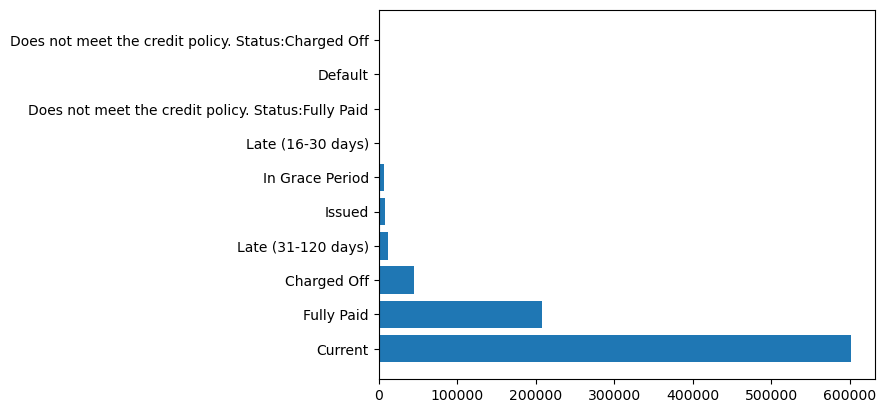

In [8]:
# Checking what kind of values does the Loan Status have
plt.barh(loan_sts.value_counts().index, loan_sts.value_counts())
plt.show()

#### Loan Status
Before Getting into feature engineering lets understand about the loan status. I have created 4 different categories for given statuses.

1. Issued (Category 0)
- Recently issued a fresh loan to borrower
2. Current, Fully Paid, Does not meet the credit policy. Status:Fully Paid (Category 1)
- Current - All outstanding payments are paid up to date
- Fully Paid - All outstanding payments are paid up and loan is finished
3. In Grace Period, Late (16-30 days), Late (31-120 days) (Category 2)
- In Grace Period - 1-15 days passed after the due date
- Late (16-30 days) - 16-30 days passed after the due date
- Late (31-120 days) - 31-120 days passed after the due date
4. Charged Off , Does not meet the credit policy. Status:Charged Off, Default (Category 3)
- Default - The borrower is not able to make outstanding payments for an extended period of time
- Charged Off - A charge-off usually occurs when the creditor has deemed an outstanding debt is uncollectible

In [9]:
# Removing entries where loan does not meet credit policy
# They are avery small proportion and could cause ambiguity in prediction model
loan_data_policy_df = loan_data_df[(loan_data_df['loan_status'] != 'Does not meet the credit policy. Status:Fully Paid') &\
  (loan_data_df['loan_status'] != 'Does not meet the credit policy. Status:Charged Off')]

> For the bank,Late 31-120, Default, Charged off are BAD LOANS - (Label 1)
> Unit Late 16-30 days, the loan can be assumed a GOOD LOAN - (Label 0)

In [10]:
# Making a custom encoder dictionary for loan status based on risk level
loan_risk_dict = { 
                    'Issued': -2,
                    'Current': -1,
                    'Fully Paid': 0,
                    'In Grace Period': 0,
                    'Late (16-30 days)': 0,
                    'Late (31-120 days)': 1,
                    'Default': 1,
                    'Charged Off': 1      
       }

In [11]:
# Encoding the output labels
loan_data_policy_df['loan_risk_sts'] = loan_data_policy_df['loan_status'].apply(lambda s: loan_risk_dict[s])

/tmp/ipykernel_23/2653396265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_policy_df['loan_risk_sts'] = loan_data_policy_df['loan_status'].apply(lambda s: loan_risk_dict[s])


In [12]:
# List of variables whose data is available before loan application
pre_loan_columns = \
['acc_now_delinq',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'delinq_2yrs',
 'desc',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'home_ownership',
 'il_util',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'loan_amnt',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'open_acc',
 'open_acc_6m',
 'open_il_12m',
 'open_il_24m',
 'open_il_6m',
 'open_rv_12m',
 'open_rv_24m',
 'policy_code',
 'pub_rec',
 'purpose',
 'pymnt_plan',
 'revol_bal',
 'revol_util',
 'sub_grade',
 'term',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_acc',
 'total_bal_il',
 'total_cu_tl',
 'total_rev_hi_lim',
 'verification_status',
 'verification_status_joint',
 'zip_code',
 'loan_risk_sts']

pre_loan_df = loan_data_policy_df[pre_loan_columns]

In [13]:
# Separating X and y
y = pre_loan_df['loan_risk_sts']
X = pre_loan_df.drop('loan_risk_sts', axis=1)

In [14]:
y[:5]

0    0
1    1
2    0
3    0
4   -1
Name: loan_risk_sts, dtype: int64

Now, lets work on the predictors.

In [15]:
# Checking for non-numeric columns
object_cols = X.dtypes[X.dtypes == "object"].index

In [16]:
object_cols

Index(['addr_state', 'application_type', 'desc', 'earliest_cr_line',
       'emp_length', 'emp_title', 'grade', 'home_ownership',
       'initial_list_status', 'purpose', 'pymnt_plan', 'sub_grade', 'term',
       'verification_status', 'verification_status_joint', 'zip_code'],
      dtype='object')

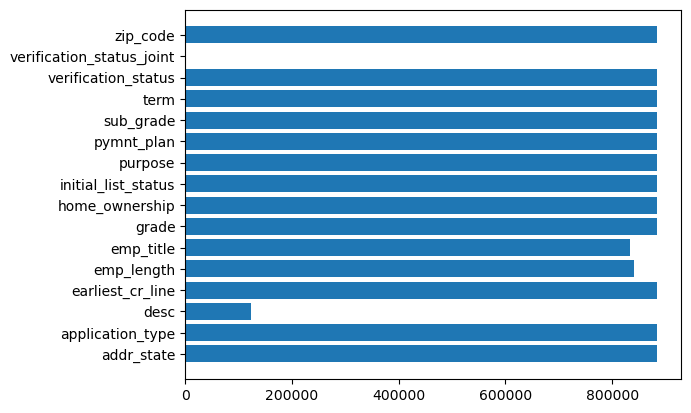

In [17]:
# Checking frequency count for non 
plt.barh(X[object_cols].count().index, X[object_cols].count())
plt.show()

Concerning columns: 
- verification_status_joint, desc, emp_length, emp_title

In [18]:
# We can drop description 
# as we do not have any sophisticated way of using it in out model.
X = X.drop('desc', axis=1)

In [19]:
# Checking the application type
X['application_type'].value_counts()

INDIVIDUAL    884119
JOINT            511
Name: application_type, dtype: int64

#### Dealing separately with Joint accounts

In [20]:
# Lets see how the counts
y[X[X['application_type'] == 'JOINT'].index].value_counts()

-1    441
-2     64
 0      4
 1      2
Name: loan_risk_sts, dtype: int64

In [21]:
y[X[X['application_type'] != 'JOINT'].index].value_counts()

-1    601338
 0    216329
 1     58056
-2      8396
Name: loan_risk_sts, dtype: int64

It appears that the Joint loans are less likely to default.

In [22]:
# For simplicity sake, let's combine dti and dti_joint as min()
X['dti_calc'] = X.apply(lambda r: min(r['dti'],r['dti_joint']), axis=1)

In [23]:
# Dropping the dti columns
X = X.drop(['dti','dti_joint'], axis=1)

In [24]:
# Encoding verification status:
def ver_encoder(row):
    ver_status_dict = {
        'Verified': 1, 
        'Source Verified': 1, 
        'Not Verified': 0,
        }
    v_ind = ver_status_dict[row['verification_status']]
    if pd.isna(row['verification_status_joint']):
        v_joint = 0
    else:
        v_joint = ver_status_dict[row['verification_status_joint']]
    return max(v_ind, v_joint)
    
X['is_verified'] = X.apply(lambda row: ver_encoder(row), axis=1)

In [25]:
# Dropping the verification columns
X = X.drop(['verification_status','verification_status_joint'], axis=1)

In [26]:
# Using max of joint and indv income as calculated income
X['annual_inc_calc'] = X.apply(lambda r: max(r['annual_inc'], r['annual_inc_joint']), axis=1)

In [27]:
# Dropping individual income columns
X = X.drop(['annual_inc','annual_inc_joint'], axis=1)

In [28]:
# Checking for non-numeric columns
object_cols = X.dtypes[X.dtypes == "object"].index
object_cols

Index(['addr_state', 'application_type', 'earliest_cr_line', 'emp_length',
       'emp_title', 'grade', 'home_ownership', 'initial_list_status',
       'purpose', 'pymnt_plan', 'sub_grade', 'term', 'zip_code'],
      dtype='object')

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884630 entries, 0 to 887378
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   acc_now_delinq               884630 non-null  float64
 1   addr_state                   884630 non-null  object 
 2   all_util                     21372 non-null   float64
 3   application_type             884630 non-null  object 
 4   delinq_2yrs                  884630 non-null  float64
 5   earliest_cr_line             884630 non-null  object 
 6   emp_length                   839839 non-null  object 
 7   emp_title                    833327 non-null  object 
 8   funded_amnt                  884630 non-null  float64
 9   funded_amnt_inv              884630 non-null  float64
 10  grade                        884630 non-null  object 
 11  home_ownership               884630 non-null  object 
 12  il_util                      18617 non-null   float64
 13 

In [30]:
# Filling Null values in ownership as ANY
X['home_ownership'] = X['home_ownership'].fillna('ANY')

In [31]:
# Getting earliest credit line issue year
X['cr_line_yr'] = X['earliest_cr_line'].apply(lambda x: int(x.split('-')[1]))

In [32]:
# Setting dummy var for term
X['term_60'] = pd.get_dummies(X['term'], drop_first=True)
X = X.drop('term', axis=1)

In [33]:
# Dropping useless columns
drop_cols = ['emp_title', 'emp_length','earliest_cr_line', 'zip_code']
X = X.drop(drop_cols, axis=1)

In [34]:
# Encoding categorical Variables
categorical_vars = ['addr_state', 'application_type', 'grade', 'home_ownership',
 'initial_list_status', 'purpose', 'pymnt_plan', 'sub_grade']
X_encoded = pd.get_dummies(X[categorical_vars])
X_cont = X.drop(categorical_vars, axis=1)
X = pd.concat([X_cont, X_encoded], axis=1)

## Model Selection
Let's fit an Xgboost model first to understand feature importance

#### At this point, let's seperate out New and current loans
We will use the model to predict the risk on those.

In [35]:
Xs = X[y >= 0]
ys = y[y >= 0]

In [36]:
x_train, x_test, y_train, y_test = train_test_split(Xs, ys,
                                                    train_size=0.6,
                                                    random_state=0,
                                                    stratify=ys)

In [37]:
xgb = XGBClassifier()
cv = StratifiedKFold(n_splits=5)
cv_results = cross_validate(xgb, x_train, y_train, cv=cv)

In [38]:
# Printing model performance metrics
print(f"""Average accuracy = {round(np.mean(cv_results['test_score'])*100, 2)} %""")
print(f"""STD in accuracy = {round(np.std(cv_results['test_score'])*100, 2)} %""")

Average accuracy = 78.75 %
STD in accuracy = 0.14 %


In [39]:
# Training Model on the training data
xgb_classifier = xgb.fit(x_train, y_train)

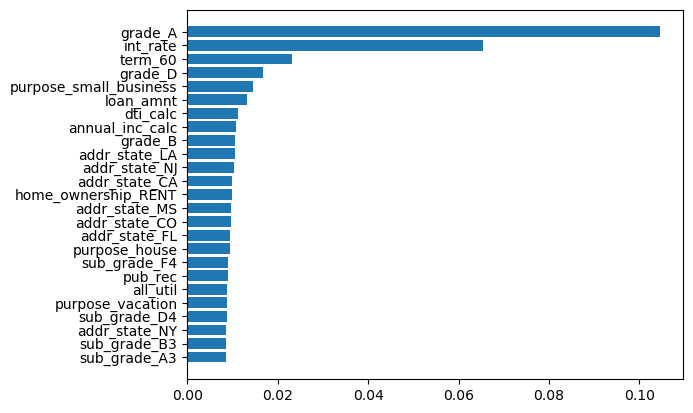

In [40]:
# Plotting the Variable according to their decreasing feature importance in tree
top = 25
sorted_index = np.array(xgb_classifier.feature_importances_).argsort()
x_ax = x_train.columns[sorted_index[-top:]]
y_ax = xgb_classifier.feature_importances_[sorted_index[-top:]]
plt.barh(x_ax, y_ax)
plt.show()

In [41]:
# Predicting test data using this model
y_test_pred = xgb.predict(x_test)
print(f"""Observed test accuracy = {round(metrics.accuracy_score(y_test, y_test_pred)*100, 2)} %""")

Observed test accuracy = 78.83 %


In [42]:
def plot_conf_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix/np.sum(conf_matrix), fmt='.2%', annot=True, cmap='Blues')
    plt.show()
    return

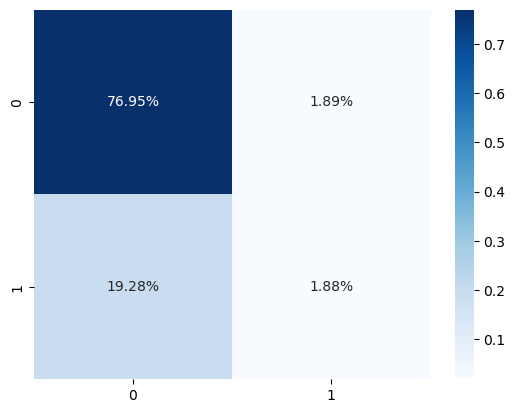

In [43]:
# Plotting confusion matrix to check where the errors are coming in from
plot_conf_matrix(y_test, y_test_pred)

#### Changing threshold value for different optimization strategy - AUC, F1

In [44]:
# Predicting test data using a lower threshold value
threshold = 0.3
y_test_pred_prob = xgb.predict_proba(x_test)
y_test_pred= (y_test_pred_prob[:,1] > threshold) 

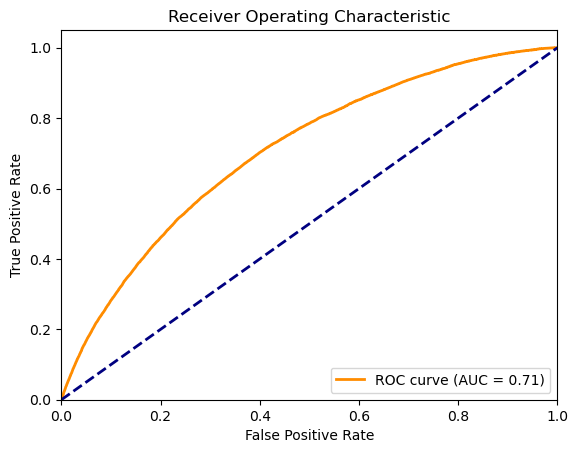

In [45]:
# Calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_prob[:,1])

# Calculate the area under the ROC curve (AUC)
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [46]:
f1 = []
for t in range(0,101):
    y_pred = (y_test_pred_prob[:,1] >= t/100).astype(int)
    # F1 Score
    f = metrics.f1_score(y_test, y_pred)
    f1.append(f)

In [47]:
pd.DataFrame({'Threshold':[i/100 for i in range(0,101)], 'F1':f1})

,Threshold,F1
0,0.00,0.349271
1,0.01,0.349834
2,0.02,0.352263
3,0.03,0.356430
4,0.04,0.361074
...,...,...
96,0.96,0.000000
97,0.97,0.000000
98,0.98,0.000000
99,0.99,0.000000


In [48]:
# Predicting test data using the threshold with max F1 score
threshold = 0.2
y_test_pred= (y_test_pred_prob[:,1] > threshold) 

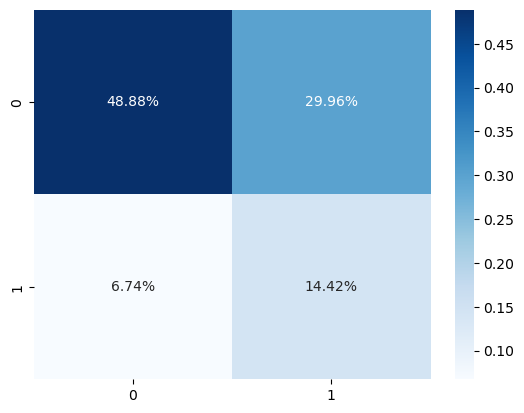

In [49]:
# Plotting confusion matrix to check where the errors are coming in from
plot_conf_matrix(y_test, y_test_pred)

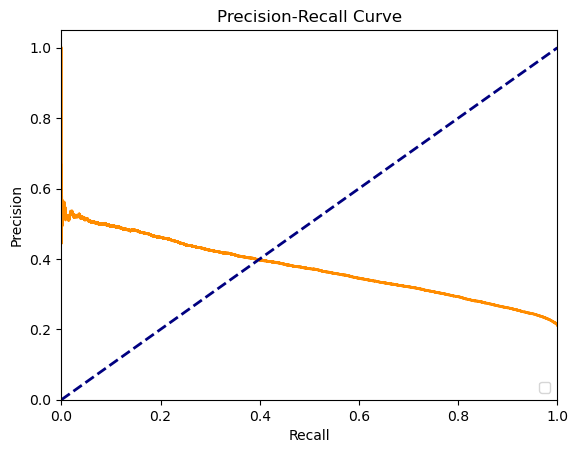

In [50]:
# Precision-Recall Curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test,y_test_pred_prob[:,1])

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

### Unused function

In [51]:
def get_monthdiff(given_date, reference_date = 'Jan-2016'):
    if pd.isna(given_date):
        return np.nan
    # Given date
    given_date = pd.to_datetime(given_date, format='%b-%Y')
    # Reference date 'Jan-2016'
    reference_date = pd.to_datetime(reference_date, format='%b-%Y')

    # Calculate the difference in months
    month_diff = math.floor((given_date - reference_date)/np.timedelta64(1, 'M'))
    
    return month_diff
# X['last_pymnt_month_diff'] = X['last_pymnt_d'].apply(lambda d: get_monthdiff(d))